# Problem Set 1 (40 points) -   Take-Home

You have been tasked to implement a predictor that will _rank_ documents according to their relevancy to a given query. 

You will use the [LETOR 4.0 dataset MQ2007]( https://arxiv.org/pdf/1306.2597.pdf) that has already been downloaded and is available in the `data` folder.

Each row is a query-document pair. The first column is the relevance label of this pair, the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. The larger the relevance label, the more relevant the query-document pair. A query-document pair is represented by a 46-dimensional feature vector. 

## PS1.A (5 points) - Data Exploration

Create a pandas frame of the dataset and _print_ the first 5 rows in format where the first row will show the column names of the dataset. Instead of the feature names you can conveniently use the column index as a name.  

Is the 2nd column which is the query id a feature or not ?  Answer the question by coding the production of the $\mathbf x$ feature container and the $label y$ label container.  

In [33]:
# Insert the code here
import pandas

#Convert whatever the heck this is right to CSV
file_in = open("Querylevelnorm.txt", "r") 
file_out = open("Querylevelnorm.csv", "w")
column_names=["relevance", "qid"]
column_names.extend(str(i + 1) for i in range(46))
file_out.write(",".join(column_names))
file_out.write("\n")
for line in file_in:
    components = line.split(" ")
    components = components[:48]
    for i in range(47):
        components[i+1] = components[i+1].split(":")[1]
    file_out.write(",".join(components))
    file_out.write("\n")



In [34]:
from sklearn.model_selection import train_test_split 

#And now read it into the dataframes for train and test data
dataframe = pandas.read_csv("Querylevelnorm.csv")
print(dataframe.head(5))
train, test = train_test_split(dataframe, test_size=0.2)
X_test = test.drop(["relevance", "qid"], axis=1).iloc[:500]
y_test = test["relevance"].iloc[:500]
X_train = train.drop(["relevance", "qid"], axis=1).iloc[:5000]
y_train = train["relevance"].iloc[:5000]


   relevance  qid         1         2     3         4         5    6    7  \
0          0   10  0.000000  0.000000  0.00  0.000000  0.000000  0.0  0.0   
1          1   10  0.031310  0.666667  0.50  0.166667  0.033206  0.0  0.0   
2          1   10  0.078682  0.166667  0.50  0.333333  0.080022  0.0  0.0   
3          1   10  0.019058  1.000000  1.00  0.500000  0.022591  0.0  0.0   
4          0   10  0.039477  0.000000  0.75  0.166667  0.040555  0.0  0.0   

     8  ...        37        38        39        40        41        42  \
0  0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.0  ...  0.646890  0.686107  0.823908  0.750092  0.385426  0.923077   
2  0.0  ...  0.649824  0.578581  0.868557  0.641385  0.010462  0.076923   
3  0.0  ...  0.918403  0.868457  1.000000  0.863460  0.016642  0.153846   
4  0.0  ...  0.565875  0.569440  0.769845  0.646567  0.073711  0.076923   

         43        44        45   46  
0  0.017241  0.000000  0.000000  0.0  
1  0.086

Looking at the unique values in the qid column, I have concluded that a query ID is not a feature as it is just an integer identifier for the query and does not pertain to any real information about it, per se. In addition, it is definitely not a continuous variable that we can perform regression on. As such, it was dropped from the test and train data.

In [35]:
print(test["qid"].unique())

[3094  871 5531 ... 5989 5715 3191]


## PS1.B (20 points)

Consult your textbook notebook `#4`` (the one that corresponds to Chapter 4) and express the problem of ranking as a regression problem. State the problem and implement the solution using the polynomial basis functions just like in [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Solve the linear regression problem using SGD. Report the train and test MSE as a function of the epochs. 


This ranking problem can be turned into a regression problem by treating the ranking as a continuous variable. We can use linear regression by applying a polynomial basis function and then performing linear regression on the transformed dataset. In addition, we will also be normalizing the data such that the means of each input variable and the mean of the output variable are 0, and undoing the normalization when we make predictions. This way we do not have to worry about the intercepts at all during training. Our weights will therefore be represented as a vector, one for each independent variable. Our prediction using $m$ data points will therefore be

$\hat{y_i} = w_1x_{i1} + w_2x_{i2} + ... + w_mx_{im}$

And our error when predicting $n$ data points will be

$Err = \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

Now we derive this with respect to a given weight, say, $w_j$.

$\frac{dErr}{dw_j} = \frac{d}{dw_j} \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

$=\frac{1}{n}\sum_{i=1}^{n} \frac{d}{dw_j} (\hat{y_i}-y_i)^2$

$\frac{d}{dw_j} (\hat{y_i}-y_i)^2 = 2(\hat{y_i}-y_i)(\frac{d}{dw_j}(\hat{y_i}-y_i))$

$\frac{d}{dw_j}(\hat{y_i}-y_i) = \frac{d}{dw_j}\hat{y_i} = \frac{d}{dw_j}w_jx_{ij} = x_{ij}$

$\frac{dErr}{dw_j} = \frac{2}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)x_{ij}$

In the case of stoachastic gradient descent, we have $n=1$

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j$

We now have the mathematical TRUTH we need to implement SGD from scratch. Even in C if we so chose. In order to verify that we have not made a fatal error in mathematical reasoning or in implementation, we will first test the algorithm on a toy dataset, and then the actual data.

initializing
Training
Epoch 1 train mse: 0.25469395496784797
Epoch 2 train mse: 0.2545041525174087
Epoch 3 train mse: 0.2543412982511825
Epoch 4 train mse: 0.25282401194196796
Epoch 5 train mse: 0.2528085997331621
Epoch 6 train mse: 0.2528034839435677
Epoch 7 train mse: 0.2524256614569747
Epoch 8 train mse: 0.25196239212619853
Epoch 9 train mse: 0.2515004765596569
Epoch 10 train mse: 0.2510180240889818
Epoch 11 train mse: 0.2505093377988549
Epoch 12 train mse: 0.2503388083542712
Epoch 13 train mse: 0.24963524846293444
Epoch 14 train mse: 0.24873639665125366
Epoch 15 train mse: 0.24816660463361814
Epoch 16 train mse: 0.24698139526870597
Epoch 17 train mse: 0.24698415387614756
Epoch 18 train mse: 0.245810406899297
Epoch 19 train mse: 0.24489818144240452
Epoch 20 train mse: 0.24108787849942456
Epoch 21 train mse: 0.24059235882731045
Epoch 22 train mse: 0.24050345931373068
Epoch 23 train mse: 0.23725864603947672
Epoch 24 train mse: 0.23628335600889833
Epoch 25 train mse: 0.2361633221022102

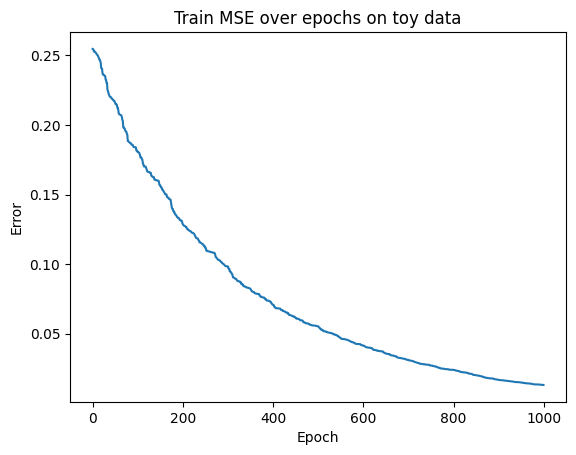

initializing
Training
Epoch 1 test mse: 0.33267454658338275
Epoch 1 train mse: 0.3411269710886447
Epoch 21 test mse: 0.3294386600034786
Epoch 21 train mse: 0.3383938040411607
Epoch 41 test mse: 0.3287867960579397
Epoch 41 train mse: 0.33790465241093715
Epoch 61 test mse: 0.32772593647690607
Epoch 61 train mse: 0.33662112349155987
Epoch 81 test mse: 0.32742589435119773
Epoch 81 train mse: 0.33625573970412515
Epoch 101 test mse: 0.3262127137433753
Epoch 101 train mse: 0.3351007589978254
Epoch 121 test mse: 0.32589509255333293
Epoch 121 train mse: 0.3349308695575826
Epoch 141 test mse: 0.32510567253991507
Epoch 141 train mse: 0.33426839577953177
Epoch 161 test mse: 0.32453051443937614
Epoch 161 train mse: 0.333839015748795
Epoch 181 test mse: 0.324603423218824
Epoch 181 train mse: 0.3340719987452317
Epoch 201 test mse: 0.3250181756210716
Epoch 201 train mse: 0.3347076745497676
Epoch 221 test mse: 0.32407878322977784
Epoch 221 train mse: 0.33369752378881723
Epoch 241 test mse: 0.3235535810

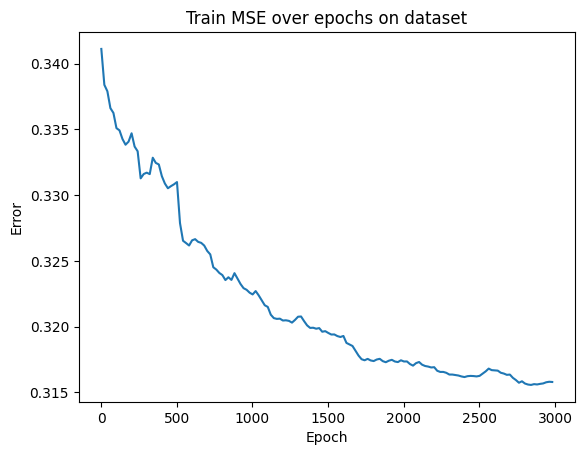

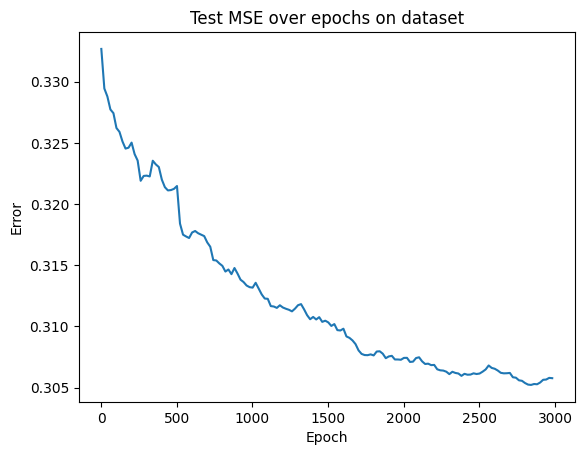

In [39]:
# Insert code here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy
import random
from matplotlib import pyplot as plt

class Model:
    def __init__(self, X: list[list[float]], y: list[float], store_errors: bool = False, error_skip_length: int = 1, X_test: list[list[float]] = None, y_test: list[float] = None):
        assert len(X) > 0
        print("initializing")
        self.store_errors = store_errors
        self.error_skip_length = error_skip_length
        self.errors_train = [] # Will store the MSE as a function of epochs 
        self.errors_test = []
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

        self.X_test = X_test
        self.y_test = y_test
    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors_test = []
        self.errors_train = []
        for i in range(epochs):
                
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] 
                self.coefficients[weight_index] -= learning_rate * gradient

            # Calculate MSE for train and test data and store it
            # This is just for metrics, but unfortunately takes a vast majority
            # of the computational power in this algorithm.
            # As such, I have added an extra parameter, "error_skip_length"
            # This will be used so that it only finds and stores the MSE at every error_skip_length'th epoch.
            if self.store_errors and i % self.error_skip_length == 0:
                if self.X_test != None and self.y_test != None:
                    assert len(self.X_test) > 0
                    assert len(self.X_test[0]) == len(self.X[0])

                    predictions = []
                    for j in range(len(self.X_test)):
                        predictions.append(self.predict(self.X_test[j]))
                    mse = mean_squared_error(self.y_test, predictions)
                    print("Epoch " + str(i + 1) + " test mse: " + str(mse))
                    self.errors_test.append(mean_squared_error(self.y_test, predictions))
     

                predictions = []
                for j in range(len(self.X)):
                    predictions.append(self.predict_normalized(self.X[j]))
                mse = mean_squared_error(self.y, predictions)
                print("Epoch " + str(i + 1) + " train mse: " + str(mse))
                self.errors_train.append(mse)
            

#To test the validity of our algorithm, we will test it on some toy data with 3 features
toy_data_x= []
toy_data_y = []
for i in range(10000):
    gen_w = random.random()
    gen_x = random.random()
    gen_z = random.random() + 10
    gen_y = gen_w + gen_x + gen_z + random.random() * 0.2 + 10
    toy_data_x.append([gen_w, gen_x, gen_z])
    toy_data_y.append(gen_y)

model = Model(toy_data_x, toy_data_y, store_errors=True)
model.fit(1000, 0.01)
x_axis = [i for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on toy data")
plt.show()

#Now we will regress on the actual dataset using polynomial basis functions. HERE GOES!!!!
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train).tolist()
y_train_transformed = y_train.values.tolist()

X_test_transformed = poly.fit_transform(X_test).tolist()
y_test_transformed = y_test.values.tolist()

error_skip_length=20
model = Model(X_train_transformed, y_train_transformed, store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
model.fit(3000, 0.0001)

x_axis = [error_skip_length * i + 1 for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset")
plt.show()

plt.plot(x_axis, model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset")
plt.show()

So, we can see that the algorithm performed extremely well on the toy data (which is to be expected as the toy data was basically designed to be well-suited to multiple linear regression). On the actual data, it was still able to do something, but the reduction in MSE was somewhat underwhelming in comparison. The underwhelming reduction in MSE could be partially explained by the fact that the pre-trained model predicts the mean of all relevances as the prediction for relevance by standardizing the data to have a mean of 0 and having a vector of all 0's as the initial weight vector. This in itself is in the ballpark of already being accurate, meaning there was less to improve upon.

## PS1.C (15 points)

Repeat the exercise of PS 1.B with the additional regualrization approach of  [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Optimize $\lambda$ showing the train and test MSE as a function of this hyperparameter and for the optimal value of $\lambda$ plot the final train and test MSE as a function of the epochs.

So, when doing linear regression, it looks like we are now adding an extra term $\frac{\lambda}{2}||w||^2$. Our loss function for $m$ features is now

$Err = (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}||w||^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}\sqrt{w_1^2 + w_2^2 + ... + w_m^2}^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_m^2)$

To calculate the derivative of this term with respect to a weight $w_j$, it looks like it's just going to be the power rule to give us

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j + \lambda w_j$

Which gives us our new gradient.

I will optimize this hyperparameter using optuna.

[I 2023-10-23 03:01:56,574] A new study created in memory with name: no-name-890d3ac4-cf21-4b77-b6f3-d7b1daa22819


initializing


[I 2023-10-23 03:01:58,075] Trial 0 finished with value: 0.32384788773450257 and parameters: {'special_hyperparameter': 17.398865573141677}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:01:59,582] Trial 1 finished with value: 0.3269336508836395 and parameters: {'special_hyperparameter': 63.40697833208001}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:01,080] Trial 2 finished with value: 0.33791241859381876 and parameters: {'special_hyperparameter': 3.762763317225326}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:02,557] Trial 3 finished with value: 0.3579517867513175 and parameters: {'special_hyperparameter': 0.6744513496266702}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:04,010] Trial 4 finished with value: 0.32718132311242304 and parameters: {'special_hyperparameter': 89.56064269157454}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:05,476] Trial 5 finished with value: 0.3265799762675905 and parameters: {'special_hyperparameter': 11.216714370991031}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:06,952] Trial 6 finished with value: 0.32856159581490885 and parameters: {'special_hyperparameter': 60.148932952247556}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:08,416] Trial 7 finished with value: 0.3267923561933159 and parameters: {'special_hyperparameter': 10.34653822943421}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:09,882] Trial 8 finished with value: 0.3274409909001059 and parameters: {'special_hyperparameter': 97.6113483161174}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:11,337] Trial 9 finished with value: 0.3270616805510509 and parameters: {'special_hyperparameter': 58.70138691478526}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing
Training


[I 2023-10-23 03:02:12,813] Trial 10 finished with value: 0.32448924801793655 and parameters: {'special_hyperparameter': 29.58991364643348}. Best is trial 0 with value: 0.32384788773450257.


initializing


[I 2023-10-23 03:02:14,273] Trial 11 finished with value: 0.3262859792331204 and parameters: {'special_hyperparameter': 35.486085408224795}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:15,742] Trial 12 finished with value: 0.3250405390827182 and parameters: {'special_hyperparameter': 28.26920432145905}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:17,203] Trial 13 finished with value: 0.3248407355102027 and parameters: {'special_hyperparameter': 28.1523043663487}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:18,658] Trial 14 finished with value: 0.32615185221989634 and parameters: {'special_hyperparameter': 38.40156272607836}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:20,127] Trial 15 finished with value: 0.3257681139189753 and parameters: {'special_hyperparameter': 18.516010414766775}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:21,602] Trial 16 finished with value: 0.3253555241321226 and parameters: {'special_hyperparameter': 20.147402040431437}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:23,066] Trial 17 finished with value: 0.3268892538069658 and parameters: {'special_hyperparameter': 42.283691199865615}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:24,531] Trial 18 finished with value: 0.32717123140270576 and parameters: {'special_hyperparameter': 47.5713703178137}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:26,014] Trial 19 finished with value: 0.3250520247788053 and parameters: {'special_hyperparameter': 24.02145792990905}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:27,468] Trial 20 finished with value: 0.32499994014483435 and parameters: {'special_hyperparameter': 34.706511580432746}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:28,923] Trial 21 finished with value: 0.3245549401471543 and parameters: {'special_hyperparameter': 26.901326203967958}. Best is trial 0 with value: 0.32384788773450257.


Training
initializing


[I 2023-10-23 03:02:30,376] Trial 22 finished with value: 0.32374131511800547 and parameters: {'special_hyperparameter': 13.750687783474929}. Best is trial 22 with value: 0.32374131511800547.


Training
initializing


[I 2023-10-23 03:02:31,868] Trial 23 finished with value: 0.3228585546127857 and parameters: {'special_hyperparameter': 13.171450392041077}. Best is trial 23 with value: 0.3228585546127857.


Training
initializing


[I 2023-10-23 03:02:33,356] Trial 24 finished with value: 0.324113303906688 and parameters: {'special_hyperparameter': 11.61544411464673}. Best is trial 23 with value: 0.3228585546127857.


Training
initializing


[I 2023-10-23 03:02:34,831] Trial 25 finished with value: 0.3271644615276141 and parameters: {'special_hyperparameter': 15.003438598745754}. Best is trial 23 with value: 0.3228585546127857.


Training
initializing
Training


[I 2023-10-23 03:02:36,310] Trial 26 finished with value: 0.3355755165418563 and parameters: {'special_hyperparameter': 0.2819581854912947}. Best is trial 23 with value: 0.3228585546127857.


initializing


[I 2023-10-23 03:02:37,789] Trial 27 finished with value: 0.3250227608251971 and parameters: {'special_hyperparameter': 7.57321644039538}. Best is trial 23 with value: 0.3228585546127857.


Training
initializing


[I 2023-10-23 03:02:39,247] Trial 28 finished with value: 0.3234432498895127 and parameters: {'special_hyperparameter': 17.84009171175567}. Best is trial 23 with value: 0.3228585546127857.


Training
initializing


[I 2023-10-23 03:02:40,755] Trial 29 finished with value: 0.32475339137651554 and parameters: {'special_hyperparameter': 16.98466324702702}. Best is trial 23 with value: 0.3228585546127857.


Training


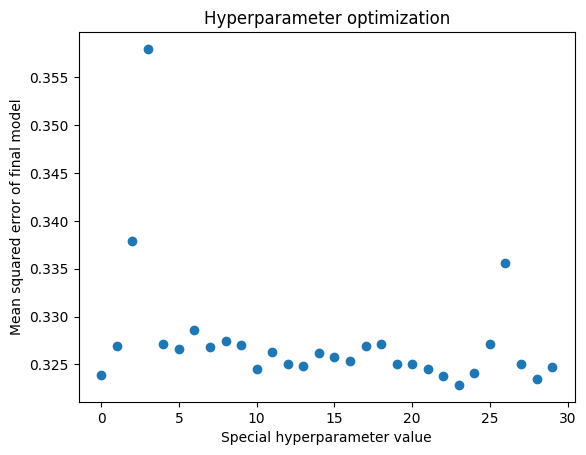

initializing
Training
Epoch 1 test mse: 0.30569480036453717
Epoch 1 train mse: 0.315714470479151
Epoch 21 test mse: 0.3053849024748691
Epoch 21 train mse: 0.3155026152793539
Epoch 41 test mse: 0.30517835168657564
Epoch 41 train mse: 0.3154234981969075
Epoch 61 test mse: 0.3050318265615098
Epoch 61 train mse: 0.31544236598092723
Epoch 81 test mse: 0.30492268392139205
Epoch 81 train mse: 0.31533705893477554
Epoch 101 test mse: 0.3049068610440518
Epoch 101 train mse: 0.31525880343638135
Epoch 121 test mse: 0.304937701545896
Epoch 121 train mse: 0.3152270659062118
Epoch 141 test mse: 0.3048540477847138
Epoch 141 train mse: 0.3151296854491697
Epoch 161 test mse: 0.30481233586652584
Epoch 161 train mse: 0.3151526747830685
Epoch 181 test mse: 0.30489781808659544
Epoch 181 train mse: 0.31500071589896306
Epoch 201 test mse: 0.30484131133699477
Epoch 201 train mse: 0.31492001002555065
Epoch 221 test mse: 0.3046681924766488
Epoch 221 train mse: 0.3149010968535172
Epoch 241 test mse: 0.30464969616

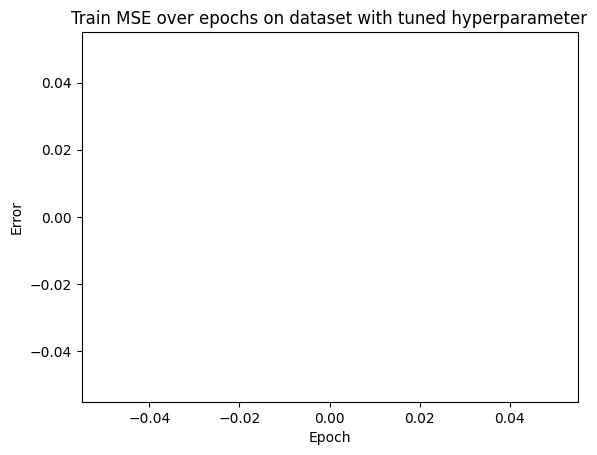

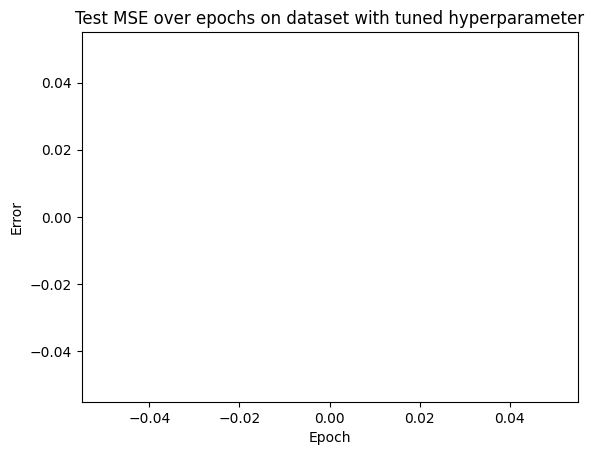

In [41]:
import optuna

class Model_2:
    def __init__(self, X: list[list[float]], y: list[float], store_errors: bool = False, special_hyperparameter=0, error_skip_length: int = 1, X_test: list[list[float]] = None, y_test: list[float] = None):
        assert len(X) > 0
        print("initializing")
        self.special_hyperparameter=special_hyperparameter
        self.store_errors = store_errors
        self.error_skip_length = error_skip_length
        self.errors_train = [] # Will store the MSE as a function of epochs 
        self.errors_test = []
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

        self.X_test = X_test
        self.y_test = y_test
    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors_test = []
        self.errors_train = []
        for i in range(epochs):
                
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] + self.special_hyperparameter * self.coefficients[weight_index]
                self.coefficients[weight_index] -= learning_rate * gradient

            # Calculate MSE for train and test data and store it
            # This is just for metrics, but unfortunately takes a vast majority
            # of the computational power in this algorithm.
            # As such, I have added an extra parameter, "error_skip_length"
            # This will be used so that it only finds and stores the MSE at every error_skip_length'th epoch.
            if self.store_errors and i % self.error_skip_length == 0:
                if self.X_test is not None and self.y_test is not None:
                    assert len(self.X_test) > 0
                    assert len(self.X_test[0]) == len(self.X[0])

                    predictions = []
                    for j in range(len(self.X_test)):
                        predictions.append(self.predict(self.X_test[j]))
                    mse = mean_squared_error(self.y_test, predictions)
                    print("Epoch " + str(i + 1) + " test mse: " + str(mse))
                    self.errors_test.append(mean_squared_error(self.y_test, predictions))
     

                predictions = []
                for j in range(len(self.X)):
                    predictions.append(self.predict_normalized(self.X[j]))
                mse = mean_squared_error(self.y, predictions)
                print("Epoch " + str(i + 1) + " train mse: " + str(mse))
                self.errors_train.append(mse)
            
errors = []
def train_regressor(trial):
    special_hyperparameter = trial.suggest_float("special_hyperparameter", low = 0, high=100)
    model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter=special_hyperparameter)
    model.fit(3000, 0.0001)


    y_pred = []
    for i in range(len(X_test_transformed)):
        y_pred.append(model.predict(X_test_transformed[i]))
    error = mean_squared_error(y_test, y_pred)
    errors.append(error)
    return error

study = optuna.create_study(direction='minimize')
study.optimize(train_regressor, n_trials=30)

x_axis = [i for i in range(len(errors))]
plt.scatter(x_axis, errors)
plt.xlabel("Special hyperparameter value")
plt.ylabel("Mean squared error of final model")
plt.title("Hyperparameter optimization")
plt.show()

error_skip_length = 20
final_model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter=study.best_params["special_hyperparameter"], store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
final_model.fit(3000, 0.0001)
x_axis = [error_skip_length * i + 1 for i in range(len(final_model.errors_train))]
plt.plot(x_axis, final_model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset with tuned hyperparameter")
plt.show()

plt.plot(x_axis, final_model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset with tuned hyperparameter")
plt.show()

Wow that did not help much at all. Nevertheless, it was successfully incorporated and did not have a significantly detrimental effect on our model, which still shows a reduction in MSE after training. We can see that the hyperparameter had a very minor effect on the model's accuracy, with the best being when it was set to 1.669798044613301. I cannot say that this definitively improved the model's performance overall. I'm sure that in another situation, this added functionality to the Model_2 class could prove useful. We will now train the model using the best value of this hyperparameter and plot MSE over epochs.

initializing
Training
Epoch 1 test mse: 0.30213698361367336
Epoch 1 train mse: 0.3118866596406539
Epoch 21 test mse: 0.30227944098532517
Epoch 21 train mse: 0.3118699161256397
Epoch 41 test mse: 0.3022109299603318
Epoch 41 train mse: 0.311822023515595
Epoch 61 test mse: 0.3021805978814818
Epoch 61 train mse: 0.31176221256249603
Epoch 81 test mse: 0.3022792390989854
Epoch 81 train mse: 0.3117694237209156
Epoch 101 test mse: 0.3024535224447961
Epoch 101 train mse: 0.31176147812435956
Epoch 121 test mse: 0.3024562180834804
Epoch 121 train mse: 0.31178986334571374
Epoch 141 test mse: 0.30248990718648117
Epoch 141 train mse: 0.31178239096299193
Epoch 161 test mse: 0.3022825302490737
Epoch 161 train mse: 0.3116945346180388
Epoch 181 test mse: 0.30238878249799245
Epoch 181 train mse: 0.3117168319419164
Epoch 201 test mse: 0.30226883044370667
Epoch 201 train mse: 0.31168445946239315
Epoch 221 test mse: 0.30221741023563076
Epoch 221 train mse: 0.31168127326860084
Epoch 241 test mse: 0.302138168

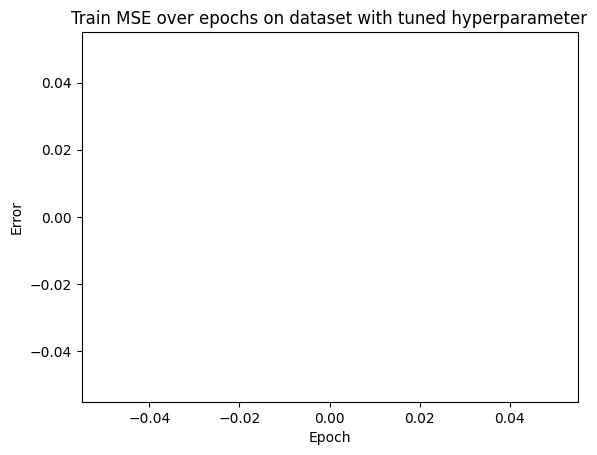

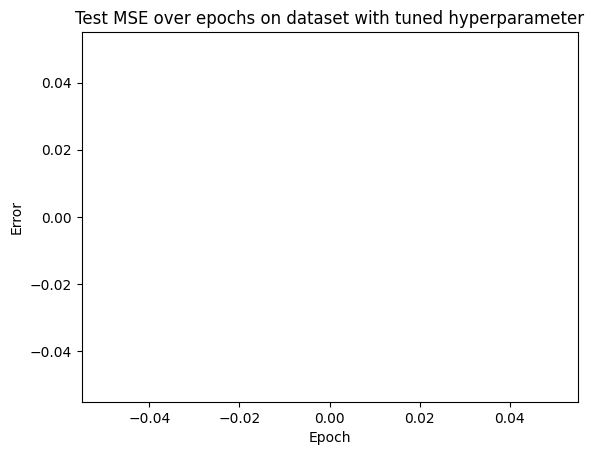

In [42]:

final_model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter=study.best_params["special_hyperparameter"], store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
final_model.fit(3000, 0.0001)
x_axis = [error_skip_length * i + 1 for i in range(len(final_model.errors_train))]
print(final_model.errors_train)
plt.plot(x_axis, final_model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset with tuned hyperparameter")
plt.show()

plt.plot(x_axis, final_model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset with tuned hyperparameter")
plt.show()

In [43]:
print(final_model.errors_train)

[]
